In [15]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, MolToImage
from torch_geometric.datasets import MoleculeNet
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import torch
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import roc_auc_score 

### HIV dataset

In [16]:
data = MoleculeNet(root="data", name="HIV")

print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

print(data[0].x)
# print(data[0].edge_index.t())
print(data[0].edge_attr.shape[1])
# print(data[0].y)
# print(data[0]["smiles"])

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  2
Dataset length:  <bound method InMemoryDataset.len of HIV(41120)>
Dataset sample:  Data(x=[19, 9], edge_index=[2, 40], edge_attr=[40, 3], smiles='CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2', y=[1, 1])
Sample  nodes:  19
Sample  edges:  40
tensor([[ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  0],
        [ 6,  0,  3,  5,  0,  0,  3,  0,  1],
        [ 8,  0,  2,  6,  0,  0,  3,  0,  1],
        [29,  0,  4,  2,  0,  0,  0,  0,  1],
        [ 8,  0,  2,  6,  0,  0,  3,  0,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  0,  1],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  0],
        [ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  1],
        [ 8,  0,  2,  6,  0,  0,  3,  0,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  0,  1],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  0],
        [ 6,  0,  4,  5,  3,  0,  4,  

<class 'rdkit.Chem.rdchem.Mol'>
CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2
label: tensor([[0.]])


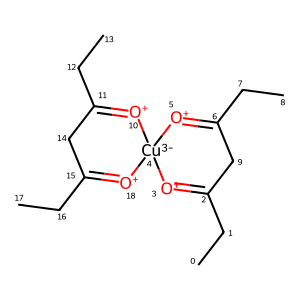

In [17]:
molecule = Chem.MolFromSmiles(data[0]["smiles"])
for atom in molecule.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()))

print(type(molecule))
print(data[0]["smiles"])
print(f"label: {data[0].y}")
MolToImage(molecule, size=(300, 300))

In [18]:
torch.manual_seed(42)
data = data.shuffle()

n_total = len(data)
n_train = int(0.8 * n_total)
n_val   = int(0.2 * n_total)

train_ds, val_ds = random_split(
    data, [n_train, n_val]
)

batch_size = 4096
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


Train batches: 9
Val batches: 3


### Model

In [19]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import TransformerConv, global_mean_pool

In [20]:
class LiteResBlock(nn.Module):
    def __init__(self, hidden, heads, edge_dim, dropout):
        super().__init__()
        self.conv1 = TransformerConv(hidden, hidden // heads,
                                     heads=heads, edge_dim=edge_dim,
                                     dropout=dropout)
        self.conv2 = TransformerConv(hidden, hidden // heads,
                                     heads=heads, edge_dim=edge_dim,
                                     dropout=dropout)
        self.norm1 = nn.LayerNorm(hidden)
        self.norm2 = nn.LayerNorm(hidden)
        self.drop  = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr):
        h = self.conv1(x, edge_index, edge_attr)
        h = F.relu(self.norm1(h))
        h = self.drop(h)

        h = self.conv2(h, edge_index, edge_attr)
        h = self.norm2(h)

        return x + self.drop(h)
        

class MiniGTRes(nn.Module):
    def __init__(
        self,
        in_dim=9,
        edge_dim=3,
        hidden=64,
        heads=4,
        dropout=0.15
    ):
        super().__init__()
        self.enc = nn.Linear(in_dim, hidden)

        self.attn = TransformerConv(hidden, hidden // heads,
                                    heads=heads, edge_dim=edge_dim,
                                    dropout=dropout)
        self.norm = nn.LayerNorm(hidden)
        self.drop = nn.Dropout(dropout)

        self.res = LiteResBlock(hidden, heads, edge_dim, dropout)

        self.mlp = nn.Sequential(
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Linear(hidden // 2, 1)
        )

    def forward(self, data):
        x = self.enc(data.x.float())
        
        # Basic layer with attention
        x = self.attn(x, data.edge_index, data.edge_attr.float())
        x = F.relu(self.norm(x))
        x = self.drop(x)

        # Residual attention layer
        x = self.res(x, data.edge_index, data.edge_attr.float())

        # Classifier
        x = global_mean_pool(x, data.batch)
        
        return self.mlp(x).squeeze(-1)


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MiniGTRes(
    in_dim=9, edge_dim=3,
    hidden=64, heads=4,
    dropout=0.15
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.7, patience=3, verbose=True)


best_auc, n_epochs = 0.0, 100

for epoch in range(1, n_epochs + 1):
    # train
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        logits = model(batch)
        targets = batch.y.float().clamp_min(0).view(-1)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch.num_graphs
    train_loss /= len(train_ds)

    # valid
    model.eval()
    val_loss = 0.0
    all_logits, all_targets = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            logits = model(batch)
            targets = batch.y.float().clamp_min(0).view(-1)

            val_loss += criterion(logits, targets).item() * batch.num_graphs
            all_logits.append(logits.cpu())
            all_targets.append(targets.cpu())

    val_loss /= len(val_ds)

    logits_cat  = torch.cat(all_logits)
    targets_cat = torch.cat(all_targets)
    val_auc = roc_auc_score(targets_cat.numpy(), logits_cat.numpy())

    scheduler.step(val_auc)
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), "best_minitgtres.pt")

    print(f"Epoch {epoch:02d} | "
          f"TrainLoss {train_loss:.4f} | "
          f"ValLoss {val_loss:.4f} | "
          f"ValAUC {val_auc:.4f}")

print(f"\nBest val AUC: {best_auc:.4f}")


Epoch 01 | TrainLoss 0.4619 | ValLoss 0.2125 | ValAUC 0.5054
Epoch 02 | TrainLoss 0.1799 | ValLoss 0.1534 | ValAUC 0.4956
Epoch 03 | TrainLoss 0.1555 | ValLoss 0.1584 | ValAUC 0.4908
Epoch 04 | TrainLoss 0.1567 | ValLoss 0.1556 | ValAUC 0.4951
Epoch 05 | TrainLoss 0.1534 | ValLoss 0.1516 | ValAUC 0.4988
Epoch 06 | TrainLoss 0.1523 | ValLoss 0.1513 | ValAUC 0.4995
Epoch 07 | TrainLoss 0.1525 | ValLoss 0.1512 | ValAUC 0.5043
Epoch 08 | TrainLoss 0.1521 | ValLoss 0.1515 | ValAUC 0.5087
Epoch 09 | TrainLoss 0.1521 | ValLoss 0.1514 | ValAUC 0.5150
Epoch 10 | TrainLoss 0.1520 | ValLoss 0.1509 | ValAUC 0.5312
Epoch 11 | TrainLoss 0.1522 | ValLoss 0.1508 | ValAUC 0.5425
Epoch 12 | TrainLoss 0.1519 | ValLoss 0.1509 | ValAUC 0.5408
Epoch 13 | TrainLoss 0.1517 | ValLoss 0.1507 | ValAUC 0.5518
Epoch 14 | TrainLoss 0.1517 | ValLoss 0.1508 | ValAUC 0.5536
Epoch 15 | TrainLoss 0.1516 | ValLoss 0.1508 | ValAUC 0.5601
Epoch 16 | TrainLoss 0.1515 | ValLoss 0.1504 | ValAUC 0.5732
Epoch 17 | TrainLoss 0.1